In [ ]:
"""

Fluida geothermal keluar dari header dengan kondisi:
- Mass flowrate: 105 kg/s
- Kualitas uap: 30%
- Tekanan: 20 bar

Diperlukan proses flashing dengan tekanan Pf, 10% uap dialirkan ke "rock muffler," sisanya ke turbin. Pressure drop dari outlet flasher ke inlet turbin adalah 0.15 bar. Sistem menggunakan single flash.  

Hitung:
1. Laju aliran uap hasil flashing,
2. Laju aliran "brine,"
3. Laju aliran uap masuk turbin,
4. Daya turbin,
5. Kalor buangan condenser.

Untuk berbagai nilai Pf: (a) 18 bar, (b) 16 bar, (c) 14 bar, (d) 12 bar, (e) 10 bar, (f) 8 bar, (g) 6 bar, (h) 4 bar, (i) 2 bar.  

**Tekanan outlet turbin (tekanan condenser):** 0.2 bar.

Asumsi: efisiensi turbin 85% dan flasher beroperasi isentalpik.
"""

hal


In [20]:
### Laju aliran uap hasil flashing
### Nilai ini dipengaruhi oleh kualitas uap flashing, Xfi
### Xfi = (h - hf) / (hg - hf)
### di mana h = h di state header
### hf = h liquid state di Pf
### hg = h vapor state di Pf
import CoolProp.CoolProp as CP
import numpy as np

def calculate_enthalpy(fluid, pressure_bar, quality):
    """
    Calculate the specific enthalpy of a fluid given pressure and quality.
    
    Parameters:
    fluid (str): The fluid name (e.g., "Water").
    pressure_bar (float): Pressure in bar.
    quality (float): Quality (mass fraction of vapor, between 0 and 1).
    
    Returns:
    float: Specific enthalpy in kJ/kg.
    """
    # Convert pressure from bar to Pascal
    pressure_pa = pressure_bar * 1e5
    
    # Calculate enthalpy
    enthalpy = CP.PropsSI('H', 'P', pressure_pa, 'Q', quality, fluid)
    
    # Convert enthalpy from J/kg to kJ/kg
    return enthalpy / 1000



def calculate_saturated_enthalpies(fluid, pressures_bar):
    """
    Calculate the enthalpy of saturated water (liquid) and vapor for a given array of pressures.
    
    Parameters:
    fluid (str): The fluid name (e.g., "Water").
    pressures_bar (list or array): Array of pressures in bar.
    
    Returns:
    tuple: Two arrays (lists) - enthalpy of saturated water and saturated vapor in kJ/kg.
    """
    h_liquid_array = []
    h_vapor_array = []
    
    for pressure_bar in pressures_bar:
        # Convert pressure from bar to Pascal
        pressure_pa = pressure_bar * 1e5
        
        # Enthalpy of saturated liquid
        h_liquid = CP.PropsSI('H', 'P', pressure_pa, 'Q', 0, fluid) / 1000  # Convert to kJ/kg
        h_liquid_array.append(h_liquid)
        
        # Enthalpy of saturated vapor
        h_vapor = CP.PropsSI('H', 'P', pressure_pa, 'Q', 1, fluid) / 1000  # Convert to kJ/kg
        h_vapor_array.append(h_vapor)
    
    return h_liquid_array, h_vapor_array


def calculate_flash_quality(h, h_satliq, h_satvap):
    """
    Calculate the quality of the flasher.
    
    Parameters:
    h (float or array-like): Specific enthalpy of the mixture (kJ/kg).
    h_satliq (float or array-like): Enthalpy of saturated liquid (kJ/kg).
    h_satvap (float or array-like): Enthalpy of saturated vapor (kJ/kg).
    
    Returns:
    float or ndarray: Quality of the flasher (0 to 1).
    """
    h_satliq = np.asarray(h_satliq)
    h_satvap = np.asarray(h_satvap)
    return (h - h_satliq) / (h_satvap - h_satliq)

def calculate_flowrate_flasher(q_flasher, header_flow):
    """
    Calculate the vapor and brine flow rates in the flasher.
    
    Parameters:
    q_flasher (array-like): Quality of the flasher (fraction of vapor).
    header_flow (float): Total mass flow rate at the header (kg/s).
    
    Returns:
    tuple: 
        - vapor_flow (ndarray): Vapor flow rate (kg/s).
        - brine_flow (ndarray): Brine flow rate (kg/s).
    """
    q_flasher = np.asarray(q_flasher)  # Ensure q_flasher is a NumPy array
    vapor_flow = q_flasher * header_flow
    brine_flow = (1 - q_flasher) * header_flow
    return vapor_flow, brine_flow


def calculate_inletflow_turbine(rock_muffler, vapor_flow):
    """
    Calculate the inlet flow rate to the turbine.
    
    Parameters:
    rock_muffler (float): Fraction of vapor diverted to the rock muffler (0 to 1).
    vapor_flow (array-like): Vapor flow rate (kg/s) as a NumPy array or array-like input.
    
    Returns:
    ndarray: Inlet flow rate to the turbine (kg/s).
    """
    vapor_flow = np.asarray(vapor_flow)  # Ensure vapor_flow is a NumPy array
    inlet_turbine_flow = (1 - rock_muffler) * vapor_flow
    return inlet_turbine_flow



def calculate_turbine_work(turbine_inlet_pressure, turbine_efficiency, inlet_flow_rate, condenser_pressure, fluid):
    """
    Calculate the turbine work output in MW.
    
    Parameters:
    turbine_inlet_pressure (array-like): Turbine inlet pressures (bar) as a NumPy array.
    turbine_efficiency (float): Turbine isentropic efficiency (0 to 1).
    inlet_flow_rate (array-like): Inlet flow rates (kg/s) as a NumPy array.
    condenser_pressure (float): Condenser pressure (bar).
    fluid (str): The working fluid (e.g., "Water", "R134a").
    
    Returns:
    ndarray: Turbine work output (MW) for each pressure and flow rate combination.
    """
    # Convert inputs to NumPy arrays and pressures to Pascals
    turbine_inlet_pressure = np.asarray(turbine_inlet_pressure) * 1e5  # Convert bar to Pa
    inlet_flow_rate = np.asarray(inlet_flow_rate)
    condenser_pressure = condenser_pressure * 1e5  # Convert bar to Pa
    
    # Calculate specific enthalpies
    h_inlet = CP.PropsSI('H', 'P', turbine_inlet_pressure, 'Q', 1, fluid)  # Sat. vapor at inlet
    h_outlet_isentropic = CP.PropsSI('H', 'P', condenser_pressure, 'S', 
                                     CP.PropsSI('S', 'P', turbine_inlet_pressure, 'Q', 1, fluid), fluid)
    
    # Isentropic enthalpy drop with efficiency accounted for
    h_actual = h_inlet - turbine_efficiency * (h_inlet - h_outlet_isentropic)
    
    # Turbine work (W = mass_flow * (h_inlet - h_actual))
    turbine_work = inlet_flow_rate * (h_inlet - h_actual)  # in W
    
    # Convert to MW
    return turbine_work / 1e6, h_actual / 1000  # Convert W to MW and J/kg to kJ/kg


def calculate_condenser_heat_loss(condenser_pressure, h_after_turbine, mass_flow_rate, fluid):
    """
    Calculate the heat losses in the condenser.
    
    Parameters:
    condenser_pressure (float): Condenser pressure (bar).
    h_after_turbine (array-like): Enthalpy after the turbine (kJ/kg).
    mass_flow_rate (array-like): Mass flow rates (kg/s) as a NumPy array.
    fluid (str): The working fluid (e.g., "Water", "R134a").
    
    Returns:
    ndarray: Heat losses by the condenser (MW).
    """
    # Convert inputs
    condenser_pressure_pa = condenser_pressure * 1e5  # Convert bar to Pa
    h_after_turbine = np.asarray(h_after_turbine)  # Ensure h_after_turbine is a NumPy array
    mass_flow_rate = np.asarray(mass_flow_rate)  # Ensure mass_flow_rate is a NumPy array

    # Enthalpy of saturated liquid at condenser pressure
    h_liquid = CP.PropsSI('H', 'P', condenser_pressure_pa, 'Q', 0, fluid) / 1000  # Convert J/kg to kJ/kg

    # Heat loss by the condenser
    q_condenser = mass_flow_rate * (h_after_turbine - h_liquid)  # in kW

    # Convert to MW
    return q_condenser / 1e3





In [21]:
# Example usage
fluid = "Water"
p_flasher = [18, 16, 14, 12, 10, 8, 6, 4, 2]  # Pressures in bar

h_liquid_array, h_vapor_array = calculate_saturated_enthalpies(fluid, p_flasher)

# Print results
print("Flasher Pressures (bar):", p_flasher)
print("Saturated Liquid Enthalpy (kJ/kg):", h_liquid_array)
print("Saturated Vapor Enthalpy (kJ/kg):", h_vapor_array)

# Example usage
fluid = "Water"
p_header = 20  # in bar
q_header = 0.3  # 30%

h_header = calculate_enthalpy(fluid, p_header, q_header)
h = h_header
print(f"Enthalpy at P = {p_header} bar and x = {q_header* 100}%: {h_header:.2f} kJ/kg")
q_flasher = calculate_flash_quality(h,h_liquid_array,h_vapor_array)
print(f"Quality of the flasher: {q_flasher}")
vapor_flow, brine_flow = calculate_flowrate_flasher(q_flasher, 105)
print(f"Vapor flow rate from flasher: {vapor_flow} kg/s")
print(f"Brine flow rate from flasher: {brine_flow} kg/s")
turbine_inlet_flow = calculate_inletflow_turbine(0.1, vapor_flow)
print(f"Inlet flow rate to the turbine: {turbine_inlet_flow} kg/s")
p_inlet_turbine = np.array(p_flasher) - 0.15
fluid = "Water"
condenser_pressure = 0.2
turbine_work,h_actual = calculate_turbine_work(p_inlet_turbine, 0.85, turbine_inlet_flow, condenser_pressure, fluid)
print(f"Turbine work output: {turbine_work} MW")
q_condenser = calculate_condenser_heat_loss(condenser_pressure, h_actual, turbine_inlet_flow, fluid)
print(f"Heat loss by the condenser: {q_condenser} MW")

Flasher Pressures (bar): [18, 16, 14, 12, 10, 8, 6, 4, 2]
Saturated Liquid Enthalpy (kJ/kg): [884.473923167349, 858.4555490496862, 829.9671228797575, 798.3286809535397, 762.5150697660875, 720.863697885437, 670.377239841194, 604.6545546714456, 504.70418503808713]
Saturated Vapor Enthalpy (kJ/kg): [2795.906875917989, 2792.817258260342, 2788.847398970472, 2783.741631314817, 2777.1086040473124, 2768.3033346536668, 2756.1428609296368, 2738.053040475813, 2706.230741339997]
Enthalpy at P = 20 bar and x = 30.0%: 1475.44 kJ/kg
Quality of the flasher: [0.3091725  0.31895838 0.32950932 0.34104127 0.35387851 0.36854456
 0.38597779 0.40816654 0.44093597]
Vapor flow rate from flasher: [32.4631129  33.49063039 34.59847884 35.80933335 37.15724392 38.69717865
 40.52766746 42.8574868  46.29827697] kg/s
Brine flow rate from flasher: [72.5368871  71.50936961 70.40152116 69.19066665 67.84275608 66.30282135
 64.47233254 62.1425132  58.70172303] kg/s
Inlet flow rate to the turbine: [29.21680161 30.14156735 3

In [31]:
from tabulate import tabulate

# Define the data for the table
table_data = list(zip(
    p_flasher,
    vapor_flow,
    brine_flow,
    turbine_inlet_flow,
    turbine_work,
    q_condenser
))

# Define the headers for the table
headers = ["Flasher Pressure (bar)", "Vapor Flow Rate (kg/s)", "Brine Flow Rate (kg/s)", "Turbine Inlet Flow (kg/s)", "Output Turbine Power (MW)", "Condenser Heat Losses (MW)"]

# Create the table
table = tabulate(table_data, headers=headers, tablefmt="grid")

# Print the table
print(table)

+--------------------------+--------------------------+--------------------------+-----------------------------+-----------------------------+------------------------------+
|   Flasher Pressure (bar) |   Vapor Flow Rate (kg/s) |   Brine Flow Rate (kg/s) |   Turbine Inlet Flow (kg/s) |   Output Turbine Power (MW) |   Condenser Heat Losses (MW) |
+==========================+==========================+==========================+=============================+=============================+==============================+
|                       18 |                  32.4631 |                  72.5369 |                     29.2168 |                     17.2717 |                      57.0639 |
+--------------------------+--------------------------+--------------------------+-----------------------------+-----------------------------+------------------------------+
|                       16 |                  33.4906 |                  71.5094 |                     30.1416 |                  

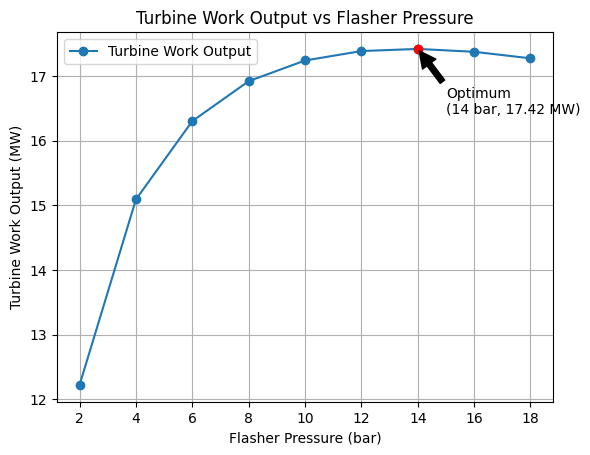

In [ ]:
import matplotlib.pyplot as plt

plt.plot(p_flasher, turbine_work, marker='o', label='Turbine Work Output')
plt.xlabel("Flasher Pressure (bar)")
plt.ylabel("Turbine Work Output (MW)")
plt.title("Turbine Work Output vs Flasher Pressure")
plt.grid(True)

# Highlight the optimum point
optimum_index = np.argmax(turbine_work)
optimum_pressure = p_flasher[optimum_index]
optimum_work = turbine_work[optimum_index]
plt.plot(optimum_pressure, optimum_work, 'ro')  # Red dot for the optimum point
plt.annotate(f'Optimum\n({optimum_pressure} bar, {optimum_work:.2f} MW)', 
             xy=(optimum_pressure, optimum_work), 
             xytext=(optimum_pressure + 1, optimum_work - 1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.show()
